### Modeling on a small subset of data

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Conv1D, Flatten, MaxPool1D
from tensorflow.keras import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import librosa
from librosa import display, beat
from librosa.feature import chroma_stft, melspectrogram
import glob 

In [30]:
def mfccs_parser(file):

    try:
        
          # here kaiser_fast is a technique used for faster extraction (though it does negatively affect quality)
        X, sample_rate = librosa.load(file, sr=42000, res_type='kaiser_fast') 
        
          # we extract mfcc feature from data, Use the mean so that scale isn't an issue.
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

#     feature = mfccs
#     label = row

    return mfccs

In [31]:
def enhanced_chroma_parser(file):

    try:
    
    # Load in the song using kaiser_fast to speed up loading
        y, sr = librosa.load(file, sr=42000, res_type='kaiser_fast')
        
        chroma_os = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=12*3)
        
        y_harm = librosa.effects.harmonic(y=y, margin=8)
        chroma_os_harm = librosa.feature.chroma_cqt(y=y_harm, sr=sr, bins_per_octave=12*3)
        
        chroma_filter = np.minimum(chroma_os_harm,
                           librosa.decompose.nn_filter(chroma_os_harm,
                                                       aggregate=np.median,
                                                       metric='cosine'))
        
        chroma_smooth = np.mean(scipy.ndimage.median_filter(chroma_filter, size=(1, 9)).T, axis=0)
    

        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

#     feature = mfccs
#     label = row

    return chroma_smooth

In [32]:
def static_tempo(file, bpm_estimate=120):
    
    y, sr = librosa.load(file, sr=42000, res_type="kaiser_fast")
    
    onset_env = librosa.onset.onset_strength(y, sr=sr)
    
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr, start_bpm=bpm_estimate)
    
    return tempo     

In [59]:
# enh_chroma = np.empty((12 ,))
# for files in glob.glob("D:\MusicSubset\*\*.mp3"):
#     enh_chroma = np.vstack((enh_chroma, enhanced_chroma_parser(files)))

In [ ]:
# np.savetxt('subset_enh_chroma.npy', enh_chroma, delimiter=',')

In [19]:
chroma = np.loadtxt('subset_enh_chroma.npy', delimiter= ',')

In [20]:
chroma.shape

(240, 12)

In [21]:
track_df = pd.read_csv('subset_df.csv')

In [78]:
X = chroma
y = track_df['genre']

lb = LabelEncoder()

y = tf.keras.utils.to_categorical(lb.fit_transform(y))

In [79]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=42, stratify=y )

In [80]:
ss = StandardScaler()

Xtrain_ss = ss.fit_transform(Xtrain)
Xtest_ss = ss.transform(Xtest)

In [81]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(180, 12)
(60, 12)
(180, 6)
(60, 6)


In [82]:
Xtrain_ss = Xtrain_ss[0].reshape((12, 1))
# Xtest_ss = Xtest_ss[0].reshape((12,1))

In [85]:
cnn_model = Sequential()

cnn_model.add(Conv1D(filters=6,
                     kernel_size=(2),
                     activation='relu',
                     input_shape=(12,1)))

cnn_model.add(MaxPool1D(pool_size = (2)))

cnn_model.add(Conv1D(16,
                     kernel_size=2,
                     activation='relu'))

cnn_model.add(MaxPool1D(pool_size=(2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(128,
                    activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(6,
                    activation="softmax"))

cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [86]:
history = cnn_model.fit(Xtrain_ss,
                        ytrain,
                        batch_size=18,
                        validation_data=(Xtest_ss, ytest),
                        epochs=200,
                        verbose=0)

ValueError: Error when checking input: expected conv1d_8_input to have 3 dimensions, but got array with shape (12, 1)

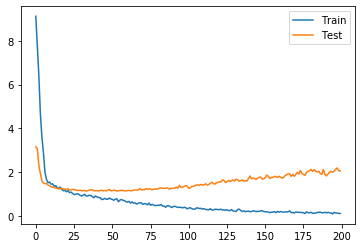

In [111]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend();

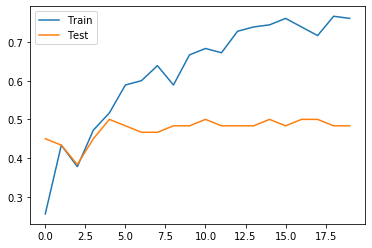

In [112]:
plt.plot(subset_history.history['accuracy'], label='Train')
plt.plot(subset_history.history['val_accuracy'], label='Test')
plt.legend();

In [58]:
model = Sequential()

model.add(Dense(256, input_shape=(12,), 
                       activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(256, 
                       activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(128, 
                       activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(6, 
                    activation='softmax'))

model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer='adam')

In [59]:
subset_history = model.fit(
    x=Xtrain_ss,
    y=ytrain,
    batch_size=18,
    epochs=20,
    validation_data=(Xtest_ss, ytest),
    verbose=2
)

Train on 180 samples, validate on 60 samples
Epoch 1/20
180/180 - 0s - loss: 1.8997 - accuracy: 0.1333 - val_loss: 1.7319 - val_accuracy: 0.2667
Epoch 2/20
180/180 - 0s - loss: 1.7299 - accuracy: 0.2444 - val_loss: 1.6593 - val_accuracy: 0.3167
Epoch 3/20
180/180 - 0s - loss: 1.6763 - accuracy: 0.2556 - val_loss: 1.5940 - val_accuracy: 0.3500
Epoch 4/20
180/180 - 0s - loss: 1.6077 - accuracy: 0.3389 - val_loss: 1.5346 - val_accuracy: 0.3333
Epoch 5/20
180/180 - 0s - loss: 1.5714 - accuracy: 0.3167 - val_loss: 1.4880 - val_accuracy: 0.3667
Epoch 6/20
180/180 - 0s - loss: 1.5499 - accuracy: 0.3667 - val_loss: 1.4705 - val_accuracy: 0.3500
Epoch 7/20
180/180 - 0s - loss: 1.5004 - accuracy: 0.3444 - val_loss: 1.4469 - val_accuracy: 0.3667
Epoch 8/20
180/180 - 0s - loss: 1.4724 - accuracy: 0.3778 - val_loss: 1.4327 - val_accuracy: 0.3667
Epoch 9/20
180/180 - 0s - loss: 1.3759 - accuracy: 0.4167 - val_loss: 1.4245 - val_accuracy: 0.3833
Epoch 10/20
180/180 - 0s - loss: 1.4247 - accuracy: 0.3

In [13]:
subset_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

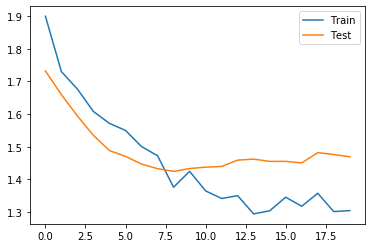

In [60]:
plt.plot(subset_history.history['loss'], label='Train')
plt.plot(subset_history.history['val_loss'], label='Test')
plt.legend();

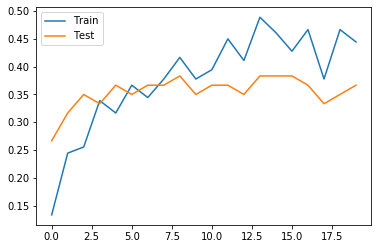

In [61]:
plt.plot(subset_history.history['accuracy'], label='Train')
plt.plot(subset_history.history['val_accuracy'], label='Test')
plt.legend();